# Group 12 Mini-project

## Dependencies

We assume a conda virtual environment is existing and selected as the kernel to run this notebook. It can be created and activated using:
```
conda env create -f environment.yml
source activate generative_prompt
```


In [ ]:
# Navigate into the source code

%cd ../src/cycle-diffusion

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

2. Install torch and torchvision

In [ ]:
!conda install -y pytorch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 pytorch-cuda=11.7 -c pytorch -c nvidia

3. Install taming-transformer

In [ ]:
%cd ..

In [ ]:
!git clone https://github.com/CompVis/taming-transformers.git
%cd taming-transformers/
!pip install -e .

In [ ]:
%cd ..

4. login to wandDB, adapt the configuration function,`setup_wandb()`, in `main.py`.


## Evaluation data
4 Prepare the AFHQ validation set for unpaired image-to-image translation (also for some images used by zero-shot image-to-image translation)

In [ ]:
%cd cycle-diffusion/
!git clone https://github.com/clovaai/stargan-v2.git
%cd stargan-v2/
!bash download.sh afhq-v2-dataset

In [ ]:
%cd ..

## Pre-trained diffusion models

5. Stable Diffusion

In [ ]:
%cd ckpts/
!mkdir stable_diffusion
%cd stable_diffusion/
!wget https://huggingface.co/CompVis/stable-diffusion-v-1-4-original/resolve/main/sd-v1-4.ckpt

In [ ]:
%cd ..

6. Latent Diffusion Model

In [ ]:
!wget https://www.dropbox.com/s/9lpdgs83l7tjk6c/ldm_models.zip
!unzip ldm_models.zip
!rm ldm_models.zip 

%cd ldm_models/
!mkdir text2img-large
%cd text2img-large/
!wget https://ommer-lab.com/files/latent-diffusion/nitro/txt2img-f8-large/model.ckpt
!wget https://www.dropbox.com/s/7pdttimz78ll0km/txt2img-1p4B-eval.yaml

In [ ]:
%cd ../..

7. DDPM (AFHQ-Dog and FFHQ are from ILVR; CelebAHQ is from SDEdit; AFHQ-Cat and -Wild are trained by ourselves)

In [ ]:
!mkdir ddpm
%cd ddpm/
# !wget https://image-editing-test-12345.s3-us-west-2.amazonaws.com/checkpoints/celeba_hq.ckpt #TODO did not work
!wget https://www.dropbox.com/s/g4h8sv07i3hj83d/ffhq_10m.pt
!wget https://www.dropbox.com/s/u74w8vaw1f8lc4k/afhq_dog_4m.pt
!wget https://www.dropbox.com/s/8i5aznjwdl3b5iq/cat_ema_0.9999_050000.pt
!wget https://www.dropbox.com/s/tplximipy8zxaub/wild_ema_0.9999_050000.pt
!wget https://www.dropbox.com/s/vqm6bxj0zslrjxv/configs.zip
!unzip configs.zip

In [ ]:
%cd ../../../..

## Run

In [4]:
# %cd cycle-diffusion

c:\Users\Alon\Documents\GitHub\cycle-diffusion-group12\src\cycle-diffusion


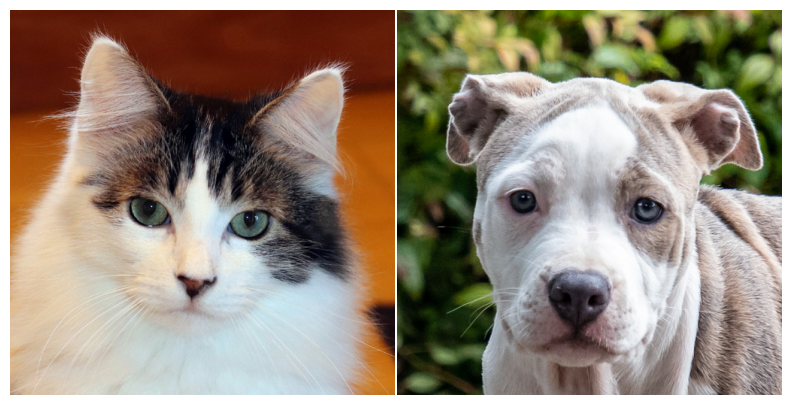

In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from PIL import Image

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image in the first subplot
img_cat = imread('stargan-test/data/test/cat/flickr_cat_000008.png')
axes[0].imshow(img_cat)
axes[0].axis('off')

# Display the second image in the second subplot
img_dog = imread('stargan-test/data/test/dog/flickr_dog_000054.png')
axes[1].imshow(img_dog)
axes[1].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0)

# Show the figure
plt.show()


In [6]:
def pass_filter(img, ftype, radius=32):
    # do dft saving as complex output
    dft = np.fft.fft2(img, axes=(0,1))

    # apply shift of origin to center of image
    dft_shift = np.fft.fftshift(dft)

    # generate spectrum from magnitude image (for viewing only)
    mag = np.abs(dft_shift)
    spec = np.log(mag) / 20

    # create circle mask
    # radius = 32
    mask = np.zeros_like(img)
    cy = mask.shape[0] // 2
    cx = mask.shape[1] // 2
    cv2.circle(mask, (cx,cy), radius, (255,255,255), -1)[0]
    if ftype == 'high':
        mask = 255 - mask

    # blur the mask
    mask = cv2.GaussianBlur(mask, (19,19), 0)

    # apply mask to dft_shift
    dft_shift_masked = np.multiply(dft_shift,mask) / 255


    # shift origin from center to upper left corner
    back_ishift = np.fft.ifftshift(dft_shift)
    back_ishift_masked = np.fft.ifftshift(dft_shift_masked)


    # do idft saving as complex output
    img_back = np.fft.ifft2(back_ishift, axes=(0,1))
    img_filtered = np.fft.ifft2(back_ishift_masked, axes=(0,1))

    # combine complex real and imaginary components to form (the magnitude for) the original image again
    img_back = np.abs(img_back).clip(0,255).astype(np.uint8)
    img_filtered = np.abs(img_filtered).clip(0,255).astype(np.uint8)

    if ftype == 'high':
        img_filtered = np.abs(3*img_filtered).clip(0,255).astype(np.uint8)
    else:
        img_filtered = np.abs(img_filtered).clip(0,255).astype(np.uint8)

    return img_filtered

### Save and plot images

In [19]:
img_cat_low = pass_filter(img_cat, 'low')
cat_low = Image.fromarray(img_cat_low)
cat_low.save("stargan-test/data/test/cat/img_cat_low.png")

img_cat_high = pass_filter(img_cat, 'high')
cat_high = Image.fromarray(img_cat_high)
cat_high.save("stargan-test/data/test/cat/img_cat_high.png")

img_dog_low = pass_filter(img_dog, 'low')
dog_low = Image.fromarray(img_dog_low)
dog_low.save("stargan-test/data/test/dog/img_dog_low.png")

img_dog_high = pass_filter(img_dog, 'high')
dog_high = Image.fromarray(img_dog_high)
dog_high.save("stargan-test/data/test/dog/img_dog_high.png")

print("Saved all images")

Saved all images


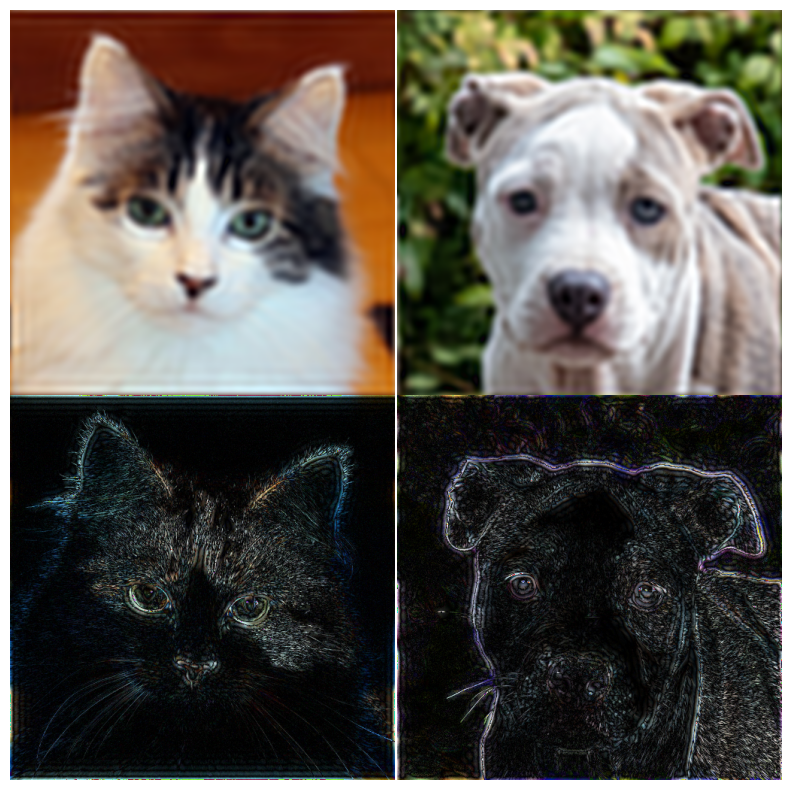

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0][0].imshow(img_cat_low)
axes[0][0].axis('off')

axes[1][0].imshow(img_cat_high)
axes[1][0].axis('off')


axes[0][1].imshow(img_dog_low)
axes[0][1].axis('off')

axes[1][1].imshow(img_dog_high)
axes[1][1].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0)

# Show the figure
plt.show()